# Effects of data quantization in circuit executions reduction

In this notebook, we evaluate how data quantization affects the number of quantum circuit executions needed to preprocess the dataset. In particular, we fix a kernel size of dimension $3\times 3$, and we compute the number of unique patches of this size given different values of quantization levels.

We compute the number of unique patches for the datasets LArTPC, MNIST, CIFAR10 (after conversion to grey scale), and MiraBest (downscaled to $30\times 30$ pixels).  

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from quanvs.quanv_util import default_encoding_config
from quanvs.Quanvolutional_Layer import QuanvolutionalLayer
from quanvs.model_builder import CNN
import constants

from quanvs.model_builder import stack_quanv_on_top
from quanvs.model_builder import get_default_model_config


config = get_default_model_config()
config["input_shape"] = (1, 30, 30)

print(config["input_shape"])

model = CNN(device="cpu", config=config)

print(model)


(1, 30, 30)
CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=7, bias=True)
)


In [7]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from utils.get_dataset.dataset_Mirabest import get_MiraBest_binary
from utils.get_dataset.dataset_LArTPC import get_LArTPC_full

def get_size_and_dataset(dataset_code):
    
    if dataset_code == "LArTPC":
        train_loader, test_loader, info = get_LArTPC_full(downscale=True, autocrop=False)
        size = 30

    elif dataset_code == "MNIST":
        transform = transforms.Compose([transforms.ToTensor()])
        trainset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform)
        testset = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)
        train_loader = DataLoader(trainset, batch_size=28, shuffle=True)
        test_loader = DataLoader(testset, batch_size=28, shuffle=True)
        size = 28

    elif dataset_code == "CIFAR10":
        transform = transforms.Compose([transforms.ToTensor()])
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
        train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
        test_loader = DataLoader(testset, batch_size=32, shuffle=True)
        size = 32

    elif dataset_code == "MiraBest":
        train_loader, test_loader, info = get_MiraBest_binary()
        size = 30

    return size, train_loader, test_loader

In [8]:
datasets_big = ["MNIST", "CIFAR10"]
datasets_small = ["LArTPC", "MiraBest"]

datasets = datasets_small + datasets_big

In [9]:
#datasets = ["LArTPC", "MNIST", "CIFAR10", "MiraBest"]

Ns = [2, 3, 5, 10, 15, 20, 30, 40, 50, 75, 100]

results = {}
for dataset_code in datasets:
    

    size, train_loader, test_loader = get_size_and_dataset(dataset_code)
    config = get_default_model_config()
    config["input_shape"] = (1, size-1, size-1)

    unique_patches = []
    #total_patches = []
    for N in Ns:
        print(f"Processing {dataset_code} with N={N}")
        model = CNN(device="cpu", config=config)

        # I want to create a quanvolutional layer
        layer = QuanvolutionalLayer(1, 1, kernel_size=3, 
                                    stride=1, padding=0,
                                    quantization=N,
                                    encoding_approach=constants.CircuitEncoding.PASS,
                                    encoding_config=default_encoding_config(constants.CircuitEncoding.PASS))



        quanvNN = stack_quanv_on_top(layer, model)

        for data, target in train_loader:
            output = quanvNN(data)

        for data, target in test_loader:
            output = quanvNN(data)

        unique = layer.counters["unique_patches"]
        unique_patches.append(unique)


    results[dataset_code] = unique_patches




700
Processing LArTPC with N=2
Processing LArTPC with N=3
Processing LArTPC with N=5
Processing LArTPC with N=10
Processing LArTPC with N=15
Processing LArTPC with N=20
Processing LArTPC with N=30
Processing LArTPC with N=40
Processing LArTPC with N=50
Processing LArTPC with N=75
Processing LArTPC with N=100
Processing MiraBest with N=2
Processing MiraBest with N=3
Processing MiraBest with N=5
Processing MiraBest with N=10
Processing MiraBest with N=15
Processing MiraBest with N=20
Processing MiraBest with N=30
Processing MiraBest with N=40
Processing MiraBest with N=50
Processing MiraBest with N=75
Processing MiraBest with N=100
Processing MNIST with N=2
Processing MNIST with N=3
Processing MNIST with N=5
Processing MNIST with N=10
Processing MNIST with N=15
Processing MNIST with N=20
Processing MNIST with N=30
Processing MNIST with N=40
Processing MNIST with N=50
Processing MNIST with N=75
Processing MNIST with N=100
Processing CIFAR10 with N=2
Processing CIFAR10 with N=3
Processing 

In [10]:
print(results)

{'LArTPC': [28, 79, 467, 2662, 5084, 7233, 10750, 13589, 16056, 20359, 23122], 'MiraBest': [75, 287, 1294, 5534, 9176, 11917, 15751, 18406, 20472, 24207, 26806], 'MNIST': [509, 12513, 172716, 1284479, 2596788, 3738222, 5410302, 6522877, 7259438, 8331144, 8993261], 'CIFAR10': [512, 11501, 206050, 3833746, 11515313, 19343310, 30566607, 37100913, 41135492, 46229319, 48640131]}


An image of size $n\times n$ contains $(n-2)\times (n-2)$ patches of size $3\times 3$. The following numbers, corresponding to the total number of patches in the dataset, can be easily obtained by multiplying the number of patches per image, by the number of images.

In [13]:
num_amount = {
    "LArTPC": 548_800,
    "MNIST": 47_320_000,
    "MiraBest": 603_680,
    "CIFAR10": 54_000_000,
}

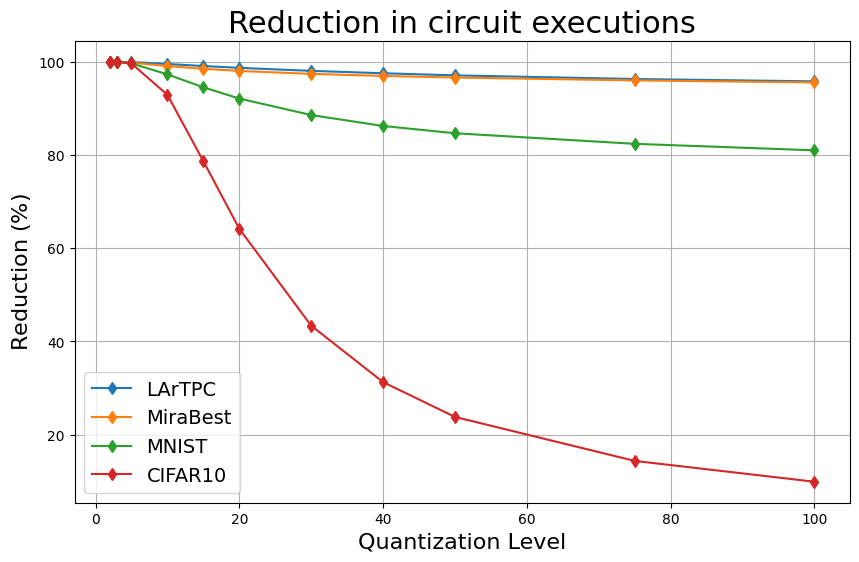

In [14]:
plt.figure(figsize=(10, 6))

for dataset in datasets:
    unique_patches = results[dataset]
    #convert from list to np.array
    unique_patches = np.array(unique_patches)
    reduction = 1-unique_patches/num_amount[dataset]
    reduction = reduction*100

    plt.plot(Ns, reduction, marker='d', label=dataset)

plt.xlabel('Quantization Level', fontsize=16)
plt.ylabel('Reduction $(\%)$', fontsize=16)
plt.title('Reduction in circuit executions', fontsize=22)
plt.legend(fontsize = 14)
plt.grid(True)

plt.show()